# word2vec_speed_improvement

source : https://github.com/WegraLee/deep-learning-from-scratch-2/tree/master/ch04


1. Embedding
2. Negative Sampling
3. Train
4. What's left

# 4.1 word2vec 개선 1

## Embedding 계층
앞 장의 word2vec 구현에서는 단어를 원핫 표현으로 바꾸고 Matmul 계층에 입력하고, Matmul 계층에서 가중치 행렬을 곱했음.
만약 여기서 어휘 수가 100만개인 경우?
이때 은닉층 뉴런이 100개라면, Matmul 행렬의 곱은 [그림 4-3]처럼 됨
만약 100만 개의 어휘를 담은 말뭉치가 있다면, 단어의 원핫 표현도 100만 차원이 됨! 거대한 벡터가 되어 가중치 행렬을 곱해야함

그러나 단지 수행하는 일은 행렬의 특정 행 추출 뿐이라 원핫 표현으로의 변환과 Matmul 계층의 행렬 곱 계산은 사실 필요 없음

그러면 가중치 매개변수로부터 '단어 ID에 해당하는 행(벡터)'을 추출하는 계층을 만들어보자. 그 계층을 Embedding 계층이라 부르자. 
Embedding 이란 단어임베딩 (word embedding)에서 유래. 즉, Embedding 계층에 단어 임베딩 (분산 표현)을 저장!

- 자연어 처리 분야에서 단어의 밀집벡터 표현을 '단어 임베팅' 혹은 단어의 '분산 표현(distributed representation) 이라 함



In [15]:
# 4.1.2 Embedding 계층 구현
# ex) 가중치 W가 2차원 넘파이 배열일 때, 이 가중치로부터 특정 행 추출

import numpy as np
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [12]:
W[2]

array([6, 7, 8])

In [13]:
W[5]

array([15, 16, 17])

In [14]:
idx = np.array([1, 0, 3, 0])
W[idx] # 인수에 배열을 사용하면 여러 행도 한꺼번에 추출할 수 있다. 미니배치 처리 가정했을 경우의 구현!

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [28]:
# Embedding 계층의 forward() 메서드 - 인스턴스 변수 params 와 grads 사용

class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout) # 중복문제 해결을 위해 해당 행에 할당이 아닌 더하기. dout를 dW의 idx번째 행에 더해줌
        # 또는
        # for i, word_id in enumerate(self.idx):
        #   dW[word_id] += dout[i]
        # 일반적으로 파이썬에서 for문 보다는 넘파이의 내장 메서드를 사용하는 편이 더 빠름. 
        
        return None

역전파를 올바르게 구현하지 못한 예

In [1]:
    def backward_bad(self, dout):
        dW, = self.grads    # 가중치 기울기 dW를 꺼낸 다음
        dW[...] = 0         # dW의 원소를 0으로 덮어씀 
        dW[self.idx] = dout # 앞 층에서 전해진 기울기 dout을 idx번째 행에 할당
        return None
    
    # idx 원소가 중복될 때 dh를 해당 행에 할당할 때 문제 발생

Embedding 계층의 순전파는 가중치 W의 특정 행을 추출할 뿐. 가중치의 특정 행 뉴런만을 (아무것도 손대지 않고) 다음 층으로 흘려보냄 <br>
역전파에서는 앞 층(출력 측 층)으로부터 전해진 기울기를 다음 층(입력 측 층)으로 그대로 흘려주면 됨. <br>
다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행(idx번째 행)에 설정 <br>

### 이제 word2vec (CBOW 모델)의 구현은 입력 측 Matmul 계층을 Embedding 계층으로 전환 가능
### => 메모리 사용량을 줄이고 쓸데없는 계산 생략 가능
-----------------







# 4.2 word2vec 개선 2

## 네거티브 샘플링 (부정적 샘플링)

남은 병목은 은닉층 이후의 처리 (행렬 곱과 softmax 계층의 계산) -> 여기서 이 병목을 해소! <br>
softmax 대신 네거티브 샘플링을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제 가능 <br>
구현이 좀 복잡 <br>
<br>

### 은닉층 이후에서 계산이 오래 걸리는 곳
    1. 은닉층의 뉴런과 가중치 행렬(W_out)의 곱
        - 거대한 행렬을 곱하는 문제
        - 시간과 메모리가 많이 필요함. 역전파 때도 같은 계산을 수행해야해서 행렬의 곱을 가볍게 만들어야함
    2. Softmax 계층의 계산
        - 어휘가 많아지면 Softmax의 계산량도 증가
        - 식을 보면, 어휘수가 100만개 일 때 분모 값 얻으려면 exp 100만번 계산해야함

### 네거티브 샘플링?
- 다중분류를 이진 분류로 근사! (multi-class classification to binary classification)
- Yes or No

- 출력층엔 뉴런을 하나만 준비하면 됨 => 'say'의 점수를 출력
- CBOW 모델 에서는 출력층의 뉴런 하나뿐. 
    - 은닉층과 출력 측의 가중치 행렬의 내적은 'say'에 해당하는 열(단어 벡터)만을 추출하고, 그 추출된 벡터와 은닉층 뉴런과의 내적을 계산하면 끝(최종점수)
    - (이전까지의 출력층에서는 모든 단어를 대상으로 계산을 수행했으나, 여기에서는 'say' 라는 단어 하나에 주목해 그 점수만 계산! & 시그모이드 함수를 이용해 그 점수를 확률로 변환)

### 시그모이드 함수와 교차 엔트로피(cross-entropy) 오차
- 이진 분류 문제를 
 - 신경망으로 풀려면 -> 점수에 시그모이드 함수를 적용해 함수로 변환
 - 손실을 구할 때 -> 손실함수로 '교차 엔트로피 오차' 사용 

=> 이 둘은 이진 분류 신경망에서 가장 흔하게 사용하는 조합 !

---------

 - 다중 분류의 경우
  - 출력층에서는 (점수를 확률로 변환할 때) 'softmax 함수'
  - 손실 함수로는 'Cross Entropy 오차'를 이용
 - 이진 분류의 경우
  - 출력층에서는 '시그모이드 함수'
  - 손실 함수로는 'Cross Entropy 오차' 이용
  
---------

- Sigmoid
 - S자 곡선형태의 그래프, 입력값(x)은 0에서 1사이의 실수로 변환
 - 출력(y)을 '확률'로 해석할 수 있다는 점이 핵심!
 - 시그모이드 함수에 사용되는 손실 함수는 '교차 엔트로피 오차'
 - y가 출력, t가 정답 레이블(0 또는 1)
 
- 이진분류과 다중분류 모두 loss function으로 '교차 엔트로피 오차'를 사용
 - 두 수식은 달라보이지만 의미는 같음. 다중 분류에서 출력층에 뉴런 2개만 쓰면 이진분류 식과 같다
 - Softmax with Loss 계층의 코드를 조금만 손보면 Sigmoid with Loss 계층도 구현할 수 있음

- 역전파의 값은 y-t
 - y : 신경망이 출력한 확률
 - t : 정답 레이블

### 네거티브 샘플링 HOW TO?
 - 긍정적 예인 'say'에 대해서만 1(yes)로 학습한 경우, 그 외의 데이터가 들어왔을 때 0에 가깝게 출력되도록 하고싶다
 - 적은 수의 (5~10) 부정적 예를 샘플링해 사용
 - 긍정적 예를 타깃으로 한 경우의 손실을 구하고, 그와 동시에 부정적 예를 몇 개 샘플링(선별)해 그에 대한 손실도 구한 후 더한 값을 최종 손실로 함
 
 
### 샘플링 기법
 - 말뭉치의 단어 빈도를 기준으로 샘플링
 - 각 단어의 출현 횟수를 구해 확률분포로 나타냄
 - 희소한 단어는 선택되기 어려움
 

In [3]:
# 확률 분포에 따라 샘플링하는 예
# np.random.choice() 메서드 사용

import numpy as np

# 0에서 9까지 숫자 중 하나를 무작위 샘플링
np.random.choice(10)

8

In [4]:
np.random.choice(10)

9

In [12]:
# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'hello'

In [13]:
# 5개만 무작위로 샘플링 (중복 있음)
np.random.choice(words, size=5)

array(['goodbye', 'you', 'say', 'I', 'you'], dtype='<U7')

In [14]:
# 5개만 무작위로 샘플링 (중복 없음)
np.random.choice(words, size=5, replace=False)

array(['goodbye', 'hello', 'I', 'you', '.'], dtype='<U7')

In [15]:
# 확률분포에 따라 샘플링 
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

- word2vec 네거티브 샘플링에서는 앞의 확률분포에서 한 가지를 수정하라고 권고 => 기본 확률분포에 0.75 제곱 
 - 출연 확률이 낮은 단어를 버리지 않기 위해서
 - 원래 확률이 낮은 단어의 확률을 살짝 높일 수 있음
 - 0.75에 이론적 의미는 없으니 다른 값으로 설정해도 됨
 
### Unigram?
- 하나의 (연속된) 단어. 바이그램은 2개, 트라이그램은 3개
- 한 단어를 대상으로 확률분포를 만든다.
- 바이그램 버전이면, 두 단어로 구성된 대상에 대한 확률분포를 만든다.

In [5]:

# negative_sampling_layer.py

# coding: utf-8
import sys
sys.path.append('..')
# from common.np import *  # import numpy as np
# from common.layers import Embedding, SigmoidWithLoss
import collections

# import 대체 
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx): # 은닉층 뉴런(h)과 단어 ID의 넘파이 배열(idx) (배열인 이유는 미니배치 처리 가정)
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1) # 내적

        self.cache = (h, target_W)
        return out

    def backward(self, dout): # 순전파의 반대순서로 기울기를 전달해 구현
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler: # 부정적 예 샘플링 
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


# 4.2.7 네거티브 샘플링 구현
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5): # 초기화 메서드
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # <- list comprehension 설명?
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

            # 0번째 계층인 loss_layers[0], embed_dot_layers[0] 이 긍정적 예를 다루는 계층
            
    # 순전파 구현
    def forward(self, h, target): # 은닉층 뉴런 h와 긍정적 예의 타깃을 뜻하는 target 
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target) # 부정적 샘플 저장

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label) # 긍/부정 샘플 각각에 대해 순전파 실행, 손실을 더함

        return loss

    def backward(self, dout=1): # 순전파 때의 역순으로 각 계층의 backward()를 호출하기만 하면 됨
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore) # 기울기 값을 더해줌 

        return dh

# 4.3 개선판 word2vec 학습

In [6]:
# 4.3.1 CBOW 모델 구현
# cbow.py

# Embedding 계층, 네거티브 샘플링 기법을 실제로 구현했으니 신경망 구현에 적용해봅시다.
# PTB 데이터셋을 사용해 학습하고 더 실용적인 단어의 분산 표현을 얻겠습니다.

# coding: utf-8
import sys
sys.path.append('..')
# from common.np import *  # import numpy as np
# from common.layers import Embedding
# from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [7]:
# skip_gram.py

# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.layers import *
# from ch04.negative_sampling_layer import NegativeSamplingLoss


class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

### 모델 학습

/Users/kakaogames/Documents/deep-learning-study/common/optimizer.py:128: RuntimeWarning: invalid value encountered in sqrt
  params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 7[s] | 손실 3.91
| 에폭 1 |  반복 121 / 9295 | 시간 9[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 손실 3.61
| 에폭 1 |  반복 161 / 9295 | 시간 12[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 14[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 15[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 16[s] | 손실 3.14
| 에폭 1 |  반복 241 / 9295 | 시간 17[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 18[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 20[s] | 손실 2.94
| 에폭 1 |  반복 301 / 9295 | 시간 21[s] | 손실 2.89
| 에폭 1 |  반복 321 / 9295 | 시간 22[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 23[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 25[s] | 손실 2.79
| 에폭 1 |  반복 381 / 9295 | 시간 26[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 27[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 28[s] | 손실 2.74
| 에폭 1 |  반복 441 / 9295

| 에폭 1 |  반복 3561 / 9295 | 시간 233[s] | 손실 2.44
| 에폭 1 |  반복 3581 / 9295 | 시간 234[s] | 손실 2.42
| 에폭 1 |  반복 3601 / 9295 | 시간 236[s] | 손실 2.40
| 에폭 1 |  반복 3621 / 9295 | 시간 237[s] | 손실 2.41
| 에폭 1 |  반복 3641 / 9295 | 시간 238[s] | 손실 2.42
| 에폭 1 |  반복 3661 / 9295 | 시간 240[s] | 손실 2.44
| 에폭 1 |  반복 3681 / 9295 | 시간 241[s] | 손실 2.41
| 에폭 1 |  반복 3701 / 9295 | 시간 242[s] | 손실 2.43
| 에폭 1 |  반복 3721 / 9295 | 시간 244[s] | 손실 2.41
| 에폭 1 |  반복 3741 / 9295 | 시간 245[s] | 손실 2.40
| 에폭 1 |  반복 3761 / 9295 | 시간 246[s] | 손실 2.41
| 에폭 1 |  반복 3781 / 9295 | 시간 247[s] | 손실 2.43
| 에폭 1 |  반복 3801 / 9295 | 시간 248[s] | 손실 2.40
| 에폭 1 |  반복 3821 / 9295 | 시간 250[s] | 손실 2.41
| 에폭 1 |  반복 3841 / 9295 | 시간 251[s] | 손실 2.42
| 에폭 1 |  반복 3861 / 9295 | 시간 252[s] | 손실 2.42
| 에폭 1 |  반복 3881 / 9295 | 시간 253[s] | 손실 2.40
| 에폭 1 |  반복 3901 / 9295 | 시간 254[s] | 손실 2.39
| 에폭 1 |  반복 3921 / 9295 | 시간 256[s] | 손실 2.41
| 에폭 1 |  반복 3941 / 9295 | 시간 257[s] | 손실 2.44
| 에폭 1 |  반복 3961 / 9295 | 시간 258[s] | 손실 2.40
| 에폭 1 |  반복 

| 에폭 1 |  반복 7061 / 9295 | 시간 450[s] | 손실 2.29
| 에폭 1 |  반복 7081 / 9295 | 시간 452[s] | 손실 2.26
| 에폭 1 |  반복 7101 / 9295 | 시간 453[s] | 손실 2.26
| 에폭 1 |  반복 7121 / 9295 | 시간 454[s] | 손실 2.29
| 에폭 1 |  반복 7141 / 9295 | 시간 456[s] | 손실 2.32
| 에폭 1 |  반복 7161 / 9295 | 시간 457[s] | 손실 2.29
| 에폭 1 |  반복 7181 / 9295 | 시간 458[s] | 손실 2.29
| 에폭 1 |  반복 7201 / 9295 | 시간 459[s] | 손실 2.27
| 에폭 1 |  반복 7221 / 9295 | 시간 460[s] | 손실 2.27
| 에폭 1 |  반복 7241 / 9295 | 시간 462[s] | 손실 2.26
| 에폭 1 |  반복 7261 / 9295 | 시간 463[s] | 손실 2.30
| 에폭 1 |  반복 7281 / 9295 | 시간 464[s] | 손실 2.27
| 에폭 1 |  반복 7301 / 9295 | 시간 465[s] | 손실 2.26
| 에폭 1 |  반복 7321 / 9295 | 시간 467[s] | 손실 2.28
| 에폭 1 |  반복 7341 / 9295 | 시간 468[s] | 손실 2.27
| 에폭 1 |  반복 7361 / 9295 | 시간 469[s] | 손실 2.24
| 에폭 1 |  반복 7381 / 9295 | 시간 470[s] | 손실 2.27
| 에폭 1 |  반복 7401 / 9295 | 시간 471[s] | 손실 2.29
| 에폭 1 |  반복 7421 / 9295 | 시간 473[s] | 손실 2.27
| 에폭 1 |  반복 7441 / 9295 | 시간 474[s] | 손실 2.27
| 에폭 1 |  반복 7461 / 9295 | 시간 475[s] | 손실 2.27
| 에폭 1 |  반복 

| 에폭 2 |  반복 1281 / 9295 | 시간 666[s] | 손실 2.13
| 에폭 2 |  반복 1301 / 9295 | 시간 667[s] | 손실 2.16
| 에폭 2 |  반복 1321 / 9295 | 시간 668[s] | 손실 2.15
| 에폭 2 |  반복 1341 / 9295 | 시간 669[s] | 손실 2.12
| 에폭 2 |  반복 1361 / 9295 | 시간 670[s] | 손실 2.10
| 에폭 2 |  반복 1381 / 9295 | 시간 672[s] | 손실 2.18
| 에폭 2 |  반복 1401 / 9295 | 시간 673[s] | 손실 2.15
| 에폭 2 |  반복 1421 / 9295 | 시간 674[s] | 손실 2.14
| 에폭 2 |  반복 1441 / 9295 | 시간 675[s] | 손실 2.16
| 에폭 2 |  반복 1461 / 9295 | 시간 677[s] | 손실 2.17
| 에폭 2 |  반복 1481 / 9295 | 시간 678[s] | 손실 2.20
| 에폭 2 |  반복 1501 / 9295 | 시간 679[s] | 손실 2.16
| 에폭 2 |  반복 1521 / 9295 | 시간 680[s] | 손실 2.16
| 에폭 2 |  반복 1541 / 9295 | 시간 682[s] | 손실 2.13
| 에폭 2 |  반복 1561 / 9295 | 시간 683[s] | 손실 2.17
| 에폭 2 |  반복 1581 / 9295 | 시간 684[s] | 손실 2.15
| 에폭 2 |  반복 1601 / 9295 | 시간 685[s] | 손실 2.13
| 에폭 2 |  반복 1621 / 9295 | 시간 686[s] | 손실 2.14
| 에폭 2 |  반복 1641 / 9295 | 시간 688[s] | 손실 2.15
| 에폭 2 |  반복 1661 / 9295 | 시간 689[s] | 손실 2.16
| 에폭 2 |  반복 1681 / 9295 | 시간 690[s] | 손실 2.15
| 에폭 2 |  반복 

| 에폭 2 |  반복 4781 / 9295 | 시간 882[s] | 손실 2.10
| 에폭 2 |  반복 4801 / 9295 | 시간 883[s] | 손실 2.07
| 에폭 2 |  반복 4821 / 9295 | 시간 884[s] | 손실 2.07
| 에폭 2 |  반복 4841 / 9295 | 시간 886[s] | 손실 2.09
| 에폭 2 |  반복 4861 / 9295 | 시간 887[s] | 손실 2.11
| 에폭 2 |  반복 4881 / 9295 | 시간 888[s] | 손실 2.08
| 에폭 2 |  반복 4901 / 9295 | 시간 889[s] | 손실 2.09
| 에폭 2 |  반복 4921 / 9295 | 시간 891[s] | 손실 2.08
| 에폭 2 |  반복 4941 / 9295 | 시간 892[s] | 손실 2.07
| 에폭 2 |  반복 4961 / 9295 | 시간 893[s] | 손실 2.09
| 에폭 2 |  반복 4981 / 9295 | 시간 894[s] | 손실 2.09
| 에폭 2 |  반복 5001 / 9295 | 시간 896[s] | 손실 2.08
| 에폭 2 |  반복 5021 / 9295 | 시간 897[s] | 손실 2.07
| 에폭 2 |  반복 5041 / 9295 | 시간 898[s] | 손실 2.09
| 에폭 2 |  반복 5061 / 9295 | 시간 899[s] | 손실 2.09
| 에폭 2 |  반복 5081 / 9295 | 시간 900[s] | 손실 2.10
| 에폭 2 |  반복 5101 / 9295 | 시간 902[s] | 손실 2.07
| 에폭 2 |  반복 5121 / 9295 | 시간 903[s] | 손실 2.06
| 에폭 2 |  반복 5141 / 9295 | 시간 904[s] | 손실 2.06
| 에폭 2 |  반복 5161 / 9295 | 시간 905[s] | 손실 2.05
| 에폭 2 |  반복 5181 / 9295 | 시간 906[s] | 손실 2.05
| 에폭 2 |  반복 

| 에폭 2 |  반복 8241 / 9295 | 시간 1093[s] | 손실 2.03
| 에폭 2 |  반복 8261 / 9295 | 시간 1094[s] | 손실 2.02
| 에폭 2 |  반복 8281 / 9295 | 시간 1095[s] | 손실 2.04
| 에폭 2 |  반복 8301 / 9295 | 시간 1097[s] | 손실 1.98
| 에폭 2 |  반복 8321 / 9295 | 시간 1098[s] | 손실 2.03
| 에폭 2 |  반복 8341 / 9295 | 시간 1099[s] | 손실 2.04
| 에폭 2 |  반복 8361 / 9295 | 시간 1100[s] | 손실 2.05
| 에폭 2 |  반복 8381 / 9295 | 시간 1101[s] | 손실 2.03
| 에폭 2 |  반복 8401 / 9295 | 시간 1103[s] | 손실 2.03
| 에폭 2 |  반복 8421 / 9295 | 시간 1104[s] | 손실 2.01
| 에폭 2 |  반복 8441 / 9295 | 시간 1105[s] | 손실 2.01
| 에폭 2 |  반복 8461 / 9295 | 시간 1106[s] | 손실 2.01
| 에폭 2 |  반복 8481 / 9295 | 시간 1107[s] | 손실 1.99
| 에폭 2 |  반복 8501 / 9295 | 시간 1109[s] | 손실 2.02
| 에폭 2 |  반복 8521 / 9295 | 시간 1110[s] | 손실 2.04
| 에폭 2 |  반복 8541 / 9295 | 시간 1111[s] | 손실 2.05
| 에폭 2 |  반복 8561 / 9295 | 시간 1112[s] | 손실 2.00
| 에폭 2 |  반복 8581 / 9295 | 시간 1113[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 1115[s] | 손실 2.00
| 에폭 2 |  반복 8621 / 9295 | 시간 1116[s] | 손실 2.02
| 에폭 2 |  반복 8641 / 9295 | 시간 1117[s] | 

| 에폭 3 |  반복 2381 / 9295 | 시간 1300[s] | 손실 1.94
| 에폭 3 |  반복 2401 / 9295 | 시간 1302[s] | 손실 1.90
| 에폭 3 |  반복 2421 / 9295 | 시간 1303[s] | 손실 1.96
| 에폭 3 |  반복 2441 / 9295 | 시간 1304[s] | 손실 1.91
| 에폭 3 |  반복 2461 / 9295 | 시간 1305[s] | 손실 1.90
| 에폭 3 |  반복 2481 / 9295 | 시간 1306[s] | 손실 1.96
| 에폭 3 |  반복 2501 / 9295 | 시간 1307[s] | 손실 1.91
| 에폭 3 |  반복 2521 / 9295 | 시간 1309[s] | 손실 1.95
| 에폭 3 |  반복 2541 / 9295 | 시간 1310[s] | 손실 1.93
| 에폭 3 |  반복 2561 / 9295 | 시간 1311[s] | 손실 1.91
| 에폭 3 |  반복 2581 / 9295 | 시간 1312[s] | 손실 1.95
| 에폭 3 |  반복 2601 / 9295 | 시간 1313[s] | 손실 1.91
| 에폭 3 |  반복 2621 / 9295 | 시간 1315[s] | 손실 1.96
| 에폭 3 |  반복 2641 / 9295 | 시간 1316[s] | 손실 1.97
| 에폭 3 |  반복 2661 / 9295 | 시간 1317[s] | 손실 1.92
| 에폭 3 |  반복 2681 / 9295 | 시간 1318[s] | 손실 1.94
| 에폭 3 |  반복 2701 / 9295 | 시간 1320[s] | 손실 1.96
| 에폭 3 |  반복 2721 / 9295 | 시간 1321[s] | 손실 1.90
| 에폭 3 |  반복 2741 / 9295 | 시간 1322[s] | 손실 1.94
| 에폭 3 |  반복 2761 / 9295 | 시간 1323[s] | 손실 1.92
| 에폭 3 |  반복 2781 / 9295 | 시간 1324[s] | 

| 에폭 3 |  반복 5801 / 9295 | 시간 1504[s] | 손실 1.93
| 에폭 3 |  반복 5821 / 9295 | 시간 1506[s] | 손실 1.88
| 에폭 3 |  반복 5841 / 9295 | 시간 1507[s] | 손실 1.89
| 에폭 3 |  반복 5861 / 9295 | 시간 1508[s] | 손실 1.88
| 에폭 3 |  반복 5881 / 9295 | 시간 1509[s] | 손실 1.94
| 에폭 3 |  반복 5901 / 9295 | 시간 1510[s] | 손실 1.91
| 에폭 3 |  반복 5921 / 9295 | 시간 1512[s] | 손실 1.91
| 에폭 3 |  반복 5941 / 9295 | 시간 1513[s] | 손실 1.91
| 에폭 3 |  반복 5961 / 9295 | 시간 1514[s] | 손실 1.91
| 에폭 3 |  반복 5981 / 9295 | 시간 1515[s] | 손실 1.87
| 에폭 3 |  반복 6001 / 9295 | 시간 1516[s] | 손실 1.92
| 에폭 3 |  반복 6021 / 9295 | 시간 1518[s] | 손실 1.89
| 에폭 3 |  반복 6041 / 9295 | 시간 1519[s] | 손실 1.86
| 에폭 3 |  반복 6061 / 9295 | 시간 1520[s] | 손실 1.90
| 에폭 3 |  반복 6081 / 9295 | 시간 1521[s] | 손실 1.91
| 에폭 3 |  반복 6101 / 9295 | 시간 1523[s] | 손실 1.91
| 에폭 3 |  반복 6121 / 9295 | 시간 1524[s] | 손실 1.91
| 에폭 3 |  반복 6141 / 9295 | 시간 1525[s] | 손실 1.93
| 에폭 3 |  반복 6161 / 9295 | 시간 1526[s] | 손실 1.92
| 에폭 3 |  반복 6181 / 9295 | 시간 1527[s] | 손실 1.92
| 에폭 3 |  반복 6201 / 9295 | 시간 1529[s] | 

| 에폭 3 |  반복 9221 / 9295 | 시간 1708[s] | 손실 1.91
| 에폭 3 |  반복 9241 / 9295 | 시간 1710[s] | 손실 1.93
| 에폭 3 |  반복 9261 / 9295 | 시간 1711[s] | 손실 1.93
| 에폭 3 |  반복 9281 / 9295 | 시간 1712[s] | 손실 1.88
| 에폭 4 |  반복 1 / 9295 | 시간 1713[s] | 손실 1.86
| 에폭 4 |  반복 21 / 9295 | 시간 1714[s] | 손실 1.85
| 에폭 4 |  반복 41 / 9295 | 시간 1715[s] | 손실 1.80
| 에폭 4 |  반복 61 / 9295 | 시간 1717[s] | 손실 1.82
| 에폭 4 |  반복 81 / 9295 | 시간 1718[s] | 손실 1.77
| 에폭 4 |  반복 101 / 9295 | 시간 1719[s] | 손실 1.78
| 에폭 4 |  반복 121 / 9295 | 시간 1720[s] | 손실 1.82
| 에폭 4 |  반복 141 / 9295 | 시간 1721[s] | 손실 1.81
| 에폭 4 |  반복 161 / 9295 | 시간 1722[s] | 손실 1.84
| 에폭 4 |  반복 181 / 9295 | 시간 1724[s] | 손실 1.79
| 에폭 4 |  반복 201 / 9295 | 시간 1725[s] | 손실 1.83
| 에폭 4 |  반복 221 / 9295 | 시간 1726[s] | 손실 1.83
| 에폭 4 |  반복 241 / 9295 | 시간 1727[s] | 손실 1.80
| 에폭 4 |  반복 261 / 9295 | 시간 1728[s] | 손실 1.84
| 에폭 4 |  반복 281 / 9295 | 시간 1729[s] | 손실 1.81
| 에폭 4 |  반복 301 / 9295 | 시간 1731[s] | 손실 1.79
| 에폭 4 |  반복 321 / 9295 | 시간 1732[s] | 손실 1.82
| 에폭 4 |  반복 34

| 에폭 4 |  반복 3361 / 9295 | 시간 1914[s] | 손실 1.80
| 에폭 4 |  반복 3381 / 9295 | 시간 1915[s] | 손실 1.85
| 에폭 4 |  반복 3401 / 9295 | 시간 1916[s] | 손실 1.83
| 에폭 4 |  반복 3421 / 9295 | 시간 1918[s] | 손실 1.78
| 에폭 4 |  반복 3441 / 9295 | 시간 1919[s] | 손실 1.81
| 에폭 4 |  반복 3461 / 9295 | 시간 1920[s] | 손실 1.80
| 에폭 4 |  반복 3481 / 9295 | 시간 1921[s] | 손실 1.83
| 에폭 4 |  반복 3501 / 9295 | 시간 1922[s] | 손실 1.81
| 에폭 4 |  반복 3521 / 9295 | 시간 1924[s] | 손실 1.80
| 에폭 4 |  반복 3541 / 9295 | 시간 1925[s] | 손실 1.80
| 에폭 4 |  반복 3561 / 9295 | 시간 1926[s] | 손실 1.83
| 에폭 4 |  반복 3581 / 9295 | 시간 1927[s] | 손실 1.84
| 에폭 4 |  반복 3601 / 9295 | 시간 1929[s] | 손실 1.84
| 에폭 4 |  반복 3621 / 9295 | 시간 1930[s] | 손실 1.80
| 에폭 4 |  반복 3641 / 9295 | 시간 1931[s] | 손실 1.78
| 에폭 4 |  반복 3661 / 9295 | 시간 1932[s] | 손실 1.79
| 에폭 4 |  반복 3681 / 9295 | 시간 1933[s] | 손실 1.84
| 에폭 4 |  반복 3701 / 9295 | 시간 1934[s] | 손실 1.83
| 에폭 4 |  반복 3721 / 9295 | 시간 1936[s] | 손실 1.80
| 에폭 4 |  반복 3741 / 9295 | 시간 1937[s] | 손실 1.80
| 에폭 4 |  반복 3761 / 9295 | 시간 1938[s] | 

| 에폭 4 |  반복 6781 / 9295 | 시간 2123[s] | 손실 1.81
| 에폭 4 |  반복 6801 / 9295 | 시간 2124[s] | 손실 1.83
| 에폭 4 |  반복 6821 / 9295 | 시간 2125[s] | 손실 1.85
| 에폭 4 |  반복 6841 / 9295 | 시간 2126[s] | 손실 1.79
| 에폭 4 |  반복 6861 / 9295 | 시간 2127[s] | 손실 1.77
| 에폭 4 |  반복 6881 / 9295 | 시간 2129[s] | 손실 1.77
| 에폭 4 |  반복 6901 / 9295 | 시간 2130[s] | 손실 1.81
| 에폭 4 |  반복 6921 / 9295 | 시간 2131[s] | 손실 1.78
| 에폭 4 |  반복 6941 / 9295 | 시간 2132[s] | 손실 1.78
| 에폭 4 |  반복 6961 / 9295 | 시간 2133[s] | 손실 1.81
| 에폭 4 |  반복 6981 / 9295 | 시간 2135[s] | 손실 1.82
| 에폭 4 |  반복 7001 / 9295 | 시간 2136[s] | 손실 1.79
| 에폭 4 |  반복 7021 / 9295 | 시간 2137[s] | 손실 1.83
| 에폭 4 |  반복 7041 / 9295 | 시간 2138[s] | 손실 1.82
| 에폭 4 |  반복 7061 / 9295 | 시간 2139[s] | 손실 1.83
| 에폭 4 |  반복 7081 / 9295 | 시간 2141[s] | 손실 1.79
| 에폭 4 |  반복 7101 / 9295 | 시간 2142[s] | 손실 1.77
| 에폭 4 |  반복 7121 / 9295 | 시간 2143[s] | 손실 1.79
| 에폭 4 |  반복 7141 / 9295 | 시간 2144[s] | 손실 1.86
| 에폭 4 |  반복 7161 / 9295 | 시간 2145[s] | 손실 1.81
| 에폭 4 |  반복 7181 / 9295 | 시간 2146[s] | 

| 에폭 5 |  반복 921 / 9295 | 시간 2329[s] | 손실 1.69
| 에폭 5 |  반복 941 / 9295 | 시간 2330[s] | 손실 1.74
| 에폭 5 |  반복 961 / 9295 | 시간 2331[s] | 손실 1.73
| 에폭 5 |  반복 981 / 9295 | 시간 2332[s] | 손실 1.75
| 에폭 5 |  반복 1001 / 9295 | 시간 2334[s] | 손실 1.71
| 에폭 5 |  반복 1021 / 9295 | 시간 2335[s] | 손실 1.74
| 에폭 5 |  반복 1041 / 9295 | 시간 2336[s] | 손실 1.71
| 에폭 5 |  반복 1061 / 9295 | 시간 2337[s] | 손실 1.73
| 에폭 5 |  반복 1081 / 9295 | 시간 2338[s] | 손실 1.73
| 에폭 5 |  반복 1101 / 9295 | 시간 2340[s] | 손실 1.69
| 에폭 5 |  반복 1121 / 9295 | 시간 2341[s] | 손실 1.74
| 에폭 5 |  반복 1141 / 9295 | 시간 2342[s] | 손실 1.73
| 에폭 5 |  반복 1161 / 9295 | 시간 2343[s] | 손실 1.68
| 에폭 5 |  반복 1181 / 9295 | 시간 2344[s] | 손실 1.73
| 에폭 5 |  반복 1201 / 9295 | 시간 2346[s] | 손실 1.74
| 에폭 5 |  반복 1221 / 9295 | 시간 2347[s] | 손실 1.77
| 에폭 5 |  반복 1241 / 9295 | 시간 2348[s] | 손실 1.71
| 에폭 5 |  반복 1261 / 9295 | 시간 2349[s] | 손실 1.72
| 에폭 5 |  반복 1281 / 9295 | 시간 2351[s] | 손실 1.72
| 에폭 5 |  반복 1301 / 9295 | 시간 2352[s] | 손실 1.73
| 에폭 5 |  반복 1321 / 9295 | 시간 2353[s] | 손실 1

| 에폭 5 |  반복 4341 / 9295 | 시간 2537[s] | 손실 1.70
| 에폭 5 |  반복 4361 / 9295 | 시간 2538[s] | 손실 1.74
| 에폭 5 |  반복 4381 / 9295 | 시간 2539[s] | 손실 1.76
| 에폭 5 |  반복 4401 / 9295 | 시간 2540[s] | 손실 1.76
| 에폭 5 |  반복 4421 / 9295 | 시간 2542[s] | 손실 1.68
| 에폭 5 |  반복 4441 / 9295 | 시간 2543[s] | 손실 1.70
| 에폭 5 |  반복 4461 / 9295 | 시간 2544[s] | 손실 1.69
| 에폭 5 |  반복 4481 / 9295 | 시간 2545[s] | 손실 1.71
| 에폭 5 |  반복 4501 / 9295 | 시간 2546[s] | 손실 1.74
| 에폭 5 |  반복 4521 / 9295 | 시간 2548[s] | 손실 1.76
| 에폭 5 |  반복 4541 / 9295 | 시간 2549[s] | 손실 1.72
| 에폭 5 |  반복 4561 / 9295 | 시간 2550[s] | 손실 1.73
| 에폭 5 |  반복 4581 / 9295 | 시간 2551[s] | 손실 1.71
| 에폭 5 |  반복 4601 / 9295 | 시간 2552[s] | 손실 1.69
| 에폭 5 |  반복 4621 / 9295 | 시간 2554[s] | 손실 1.80
| 에폭 5 |  반복 4641 / 9295 | 시간 2555[s] | 손실 1.74
| 에폭 5 |  반복 4661 / 9295 | 시간 2556[s] | 손실 1.72
| 에폭 5 |  반복 4681 / 9295 | 시간 2557[s] | 손실 1.74
| 에폭 5 |  반복 4701 / 9295 | 시간 2558[s] | 손실 1.71
| 에폭 5 |  반복 4721 / 9295 | 시간 2559[s] | 손실 1.75
| 에폭 5 |  반복 4741 / 9295 | 시간 2561[s] | 

| 에폭 5 |  반복 7761 / 9295 | 시간 2728[s] | 손실 1.71
| 에폭 5 |  반복 7781 / 9295 | 시간 2729[s] | 손실 1.70
| 에폭 5 |  반복 7801 / 9295 | 시간 2731[s] | 손실 1.75
| 에폭 5 |  반복 7821 / 9295 | 시간 2732[s] | 손실 1.72
| 에폭 5 |  반복 7841 / 9295 | 시간 2733[s] | 손실 1.74
| 에폭 5 |  반복 7861 / 9295 | 시간 2734[s] | 손실 1.74
| 에폭 5 |  반복 7881 / 9295 | 시간 2735[s] | 손실 1.73
| 에폭 5 |  반복 7901 / 9295 | 시간 2736[s] | 손실 1.71
| 에폭 5 |  반복 7921 / 9295 | 시간 2737[s] | 손실 1.77
| 에폭 5 |  반복 7941 / 9295 | 시간 2738[s] | 손실 1.72
| 에폭 5 |  반복 7961 / 9295 | 시간 2739[s] | 손실 1.74
| 에폭 5 |  반복 7981 / 9295 | 시간 2740[s] | 손실 1.69
| 에폭 5 |  반복 8001 / 9295 | 시간 2742[s] | 손실 1.75
| 에폭 5 |  반복 8021 / 9295 | 시간 2743[s] | 손실 1.72
| 에폭 5 |  반복 8041 / 9295 | 시간 2744[s] | 손실 1.73
| 에폭 5 |  반복 8061 / 9295 | 시간 2745[s] | 손실 1.70
| 에폭 5 |  반복 8081 / 9295 | 시간 2746[s] | 손실 1.73
| 에폭 5 |  반복 8101 / 9295 | 시간 2747[s] | 손실 1.75
| 에폭 5 |  반복 8121 / 9295 | 시간 2748[s] | 손실 1.71
| 에폭 5 |  반복 8141 / 9295 | 시간 2749[s] | 손실 1.71
| 에폭 5 |  반복 8161 / 9295 | 시간 2750[s] | 

| 에폭 6 |  반복 1901 / 9295 | 시간 2920[s] | 손실 1.67
| 에폭 6 |  반복 1921 / 9295 | 시간 2921[s] | 손실 1.68
| 에폭 6 |  반복 1941 / 9295 | 시간 2922[s] | 손실 1.62
| 에폭 6 |  반복 1961 / 9295 | 시간 2923[s] | 손실 1.61
| 에폭 6 |  반복 1981 / 9295 | 시간 2924[s] | 손실 1.68
| 에폭 6 |  반복 2001 / 9295 | 시간 2925[s] | 손실 1.66
| 에폭 6 |  반복 2021 / 9295 | 시간 2926[s] | 손실 1.64
| 에폭 6 |  반복 2041 / 9295 | 시간 2927[s] | 손실 1.65
| 에폭 6 |  반복 2061 / 9295 | 시간 2929[s] | 손실 1.65
| 에폭 6 |  반복 2081 / 9295 | 시간 2930[s] | 손실 1.63
| 에폭 6 |  반복 2101 / 9295 | 시간 2931[s] | 손실 1.67
| 에폭 6 |  반복 2121 / 9295 | 시간 2932[s] | 손실 1.65
| 에폭 6 |  반복 2141 / 9295 | 시간 2933[s] | 손실 1.63
| 에폭 6 |  반복 2161 / 9295 | 시간 2934[s] | 손실 1.68
| 에폭 6 |  반복 2181 / 9295 | 시간 2935[s] | 손실 1.67
| 에폭 6 |  반복 2201 / 9295 | 시간 2936[s] | 손실 1.64
| 에폭 6 |  반복 2221 / 9295 | 시간 2937[s] | 손실 1.67
| 에폭 6 |  반복 2241 / 9295 | 시간 2939[s] | 손실 1.62
| 에폭 6 |  반복 2261 / 9295 | 시간 2940[s] | 손실 1.64
| 에폭 6 |  반복 2281 / 9295 | 시간 2941[s] | 손실 1.66
| 에폭 6 |  반복 2301 / 9295 | 시간 2942[s] | 

| 에폭 6 |  반복 5321 / 9295 | 시간 3110[s] | 손실 1.69
| 에폭 6 |  반복 5341 / 9295 | 시간 3111[s] | 손실 1.65
| 에폭 6 |  반복 5361 / 9295 | 시간 3112[s] | 손실 1.64
| 에폭 6 |  반복 5381 / 9295 | 시간 3113[s] | 손실 1.64
| 에폭 6 |  반복 5401 / 9295 | 시간 3115[s] | 손실 1.66
| 에폭 6 |  반복 5421 / 9295 | 시간 3116[s] | 손실 1.64
| 에폭 6 |  반복 5441 / 9295 | 시간 3117[s] | 손실 1.62
| 에폭 6 |  반복 5461 / 9295 | 시간 3118[s] | 손실 1.65
| 에폭 6 |  반복 5481 / 9295 | 시간 3120[s] | 손실 1.69
| 에폭 6 |  반복 5501 / 9295 | 시간 3121[s] | 손실 1.61
| 에폭 6 |  반복 5521 / 9295 | 시간 3122[s] | 손실 1.61
| 에폭 6 |  반복 5541 / 9295 | 시간 3123[s] | 손실 1.67
| 에폭 6 |  반복 5561 / 9295 | 시간 3124[s] | 손실 1.67
| 에폭 6 |  반복 5581 / 9295 | 시간 3126[s] | 손실 1.62
| 에폭 6 |  반복 5601 / 9295 | 시간 3127[s] | 손실 1.70
| 에폭 6 |  반복 5621 / 9295 | 시간 3128[s] | 손실 1.63
| 에폭 6 |  반복 5641 / 9295 | 시간 3129[s] | 손실 1.68
| 에폭 6 |  반복 5661 / 9295 | 시간 3131[s] | 손실 1.67
| 에폭 6 |  반복 5681 / 9295 | 시간 3132[s] | 손실 1.64
| 에폭 6 |  반복 5701 / 9295 | 시간 3133[s] | 손실 1.62
| 에폭 6 |  반복 5721 / 9295 | 시간 3135[s] | 

| 에폭 6 |  반복 8741 / 9295 | 시간 3307[s] | 손실 1.67
| 에폭 6 |  반복 8761 / 9295 | 시간 3308[s] | 손실 1.67
| 에폭 6 |  반복 8781 / 9295 | 시간 3310[s] | 손실 1.63
| 에폭 6 |  반복 8801 / 9295 | 시간 3311[s] | 손실 1.67
| 에폭 6 |  반복 8821 / 9295 | 시간 3312[s] | 손실 1.62
| 에폭 6 |  반복 8841 / 9295 | 시간 3313[s] | 손실 1.65
| 에폭 6 |  반복 8861 / 9295 | 시간 3314[s] | 손실 1.68
| 에폭 6 |  반복 8881 / 9295 | 시간 3315[s] | 손실 1.64
| 에폭 6 |  반복 8901 / 9295 | 시간 3316[s] | 손실 1.61
| 에폭 6 |  반복 8921 / 9295 | 시간 3317[s] | 손실 1.65
| 에폭 6 |  반복 8941 / 9295 | 시간 3318[s] | 손실 1.63
| 에폭 6 |  반복 8961 / 9295 | 시간 3320[s] | 손실 1.65
| 에폭 6 |  반복 8981 / 9295 | 시간 3321[s] | 손실 1.64
| 에폭 6 |  반복 9001 / 9295 | 시간 3322[s] | 손실 1.64
| 에폭 6 |  반복 9021 / 9295 | 시간 3323[s] | 손실 1.64
| 에폭 6 |  반복 9041 / 9295 | 시간 3324[s] | 손실 1.66
| 에폭 6 |  반복 9061 / 9295 | 시간 3325[s] | 손실 1.65
| 에폭 6 |  반복 9081 / 9295 | 시간 3326[s] | 손실 1.63
| 에폭 6 |  반복 9101 / 9295 | 시간 3327[s] | 손실 1.65
| 에폭 6 |  반복 9121 / 9295 | 시간 3329[s] | 손실 1.65
| 에폭 6 |  반복 9141 / 9295 | 시간 3330[s] | 

| 에폭 7 |  반복 2881 / 9295 | 시간 3498[s] | 손실 1.60
| 에폭 7 |  반복 2901 / 9295 | 시간 3500[s] | 손실 1.59
| 에폭 7 |  반복 2921 / 9295 | 시간 3501[s] | 손실 1.56
| 에폭 7 |  반복 2941 / 9295 | 시간 3502[s] | 손실 1.57
| 에폭 7 |  반복 2961 / 9295 | 시간 3503[s] | 손실 1.59
| 에폭 7 |  반복 2981 / 9295 | 시간 3504[s] | 손실 1.55
| 에폭 7 |  반복 3001 / 9295 | 시간 3505[s] | 손실 1.57
| 에폭 7 |  반복 3021 / 9295 | 시간 3506[s] | 손실 1.58
| 에폭 7 |  반복 3041 / 9295 | 시간 3507[s] | 손실 1.61
| 에폭 7 |  반복 3061 / 9295 | 시간 3508[s] | 손실 1.60
| 에폭 7 |  반복 3081 / 9295 | 시간 3510[s] | 손실 1.55
| 에폭 7 |  반복 3101 / 9295 | 시간 3511[s] | 손실 1.57
| 에폭 7 |  반복 3121 / 9295 | 시간 3512[s] | 손실 1.57
| 에폭 7 |  반복 3141 / 9295 | 시간 3513[s] | 손실 1.54
| 에폭 7 |  반복 3161 / 9295 | 시간 3514[s] | 손실 1.61
| 에폭 7 |  반복 3181 / 9295 | 시간 3515[s] | 손실 1.60
| 에폭 7 |  반복 3201 / 9295 | 시간 3516[s] | 손실 1.58
| 에폭 7 |  반복 3221 / 9295 | 시간 3518[s] | 손실 1.56
| 에폭 7 |  반복 3241 / 9295 | 시간 3519[s] | 손실 1.60
| 에폭 7 |  반복 3261 / 9295 | 시간 3520[s] | 손실 1.59
| 에폭 7 |  반복 3281 / 9295 | 시간 3521[s] | 

| 에폭 7 |  반복 6301 / 9295 | 시간 3697[s] | 손실 1.58
| 에폭 7 |  반복 6321 / 9295 | 시간 3698[s] | 손실 1.59
| 에폭 7 |  반복 6341 / 9295 | 시간 3699[s] | 손실 1.62
| 에폭 7 |  반복 6361 / 9295 | 시간 3701[s] | 손실 1.60
| 에폭 7 |  반복 6381 / 9295 | 시간 3702[s] | 손실 1.59
| 에폭 7 |  반복 6401 / 9295 | 시간 3703[s] | 손실 1.57
| 에폭 7 |  반복 6421 / 9295 | 시간 3704[s] | 손실 1.60
| 에폭 7 |  반복 6441 / 9295 | 시간 3705[s] | 손실 1.61
| 에폭 7 |  반복 6461 / 9295 | 시간 3707[s] | 손실 1.51
| 에폭 7 |  반복 6481 / 9295 | 시간 3708[s] | 손실 1.58
| 에폭 7 |  반복 6501 / 9295 | 시간 3709[s] | 손실 1.62
| 에폭 7 |  반복 6521 / 9295 | 시간 3711[s] | 손실 1.57
| 에폭 7 |  반복 6541 / 9295 | 시간 3712[s] | 손실 1.60
| 에폭 7 |  반복 6561 / 9295 | 시간 3713[s] | 손실 1.59
| 에폭 7 |  반복 6581 / 9295 | 시간 3714[s] | 손실 1.58
| 에폭 7 |  반복 6601 / 9295 | 시간 3715[s] | 손실 1.57
| 에폭 7 |  반복 6621 / 9295 | 시간 3716[s] | 손실 1.56
| 에폭 7 |  반복 6641 / 9295 | 시간 3717[s] | 손실 1.57
| 에폭 7 |  반복 6661 / 9295 | 시간 3719[s] | 손실 1.59
| 에폭 7 |  반복 6681 / 9295 | 시간 3720[s] | 손실 1.56
| 에폭 7 |  반복 6701 / 9295 | 시간 3721[s] | 

| 에폭 8 |  반복 441 / 9295 | 시간 3895[s] | 손실 1.49
| 에폭 8 |  반복 461 / 9295 | 시간 3896[s] | 손실 1.52
| 에폭 8 |  반복 481 / 9295 | 시간 3897[s] | 손실 1.48
| 에폭 8 |  반복 501 / 9295 | 시간 3898[s] | 손실 1.50
| 에폭 8 |  반복 521 / 9295 | 시간 3900[s] | 손실 1.55
| 에폭 8 |  반복 541 / 9295 | 시간 3901[s] | 손실 1.51
| 에폭 8 |  반복 561 / 9295 | 시간 3902[s] | 손실 1.54
| 에폭 8 |  반복 581 / 9295 | 시간 3903[s] | 손실 1.50
| 에폭 8 |  반복 601 / 9295 | 시간 3904[s] | 손실 1.53
| 에폭 8 |  반복 621 / 9295 | 시간 3905[s] | 손실 1.49
| 에폭 8 |  반복 641 / 9295 | 시간 3906[s] | 손실 1.51
| 에폭 8 |  반복 661 / 9295 | 시간 3907[s] | 손실 1.50
| 에폭 8 |  반복 681 / 9295 | 시간 3908[s] | 손실 1.56
| 에폭 8 |  반복 701 / 9295 | 시간 3910[s] | 손실 1.53
| 에폭 8 |  반복 721 / 9295 | 시간 3911[s] | 손실 1.52
| 에폭 8 |  반복 741 / 9295 | 시간 3912[s] | 손실 1.54
| 에폭 8 |  반복 761 / 9295 | 시간 3913[s] | 손실 1.50
| 에폭 8 |  반복 781 / 9295 | 시간 3914[s] | 손실 1.52
| 에폭 8 |  반복 801 / 9295 | 시간 3915[s] | 손실 1.49
| 에폭 8 |  반복 821 / 9295 | 시간 3916[s] | 손실 1.49
| 에폭 8 |  반복 841 / 9295 | 시간 3918[s] | 손실 1.49
| 에폭 8 |  반복 

| 에폭 8 |  반복 3881 / 9295 | 시간 4098[s] | 손실 1.54
| 에폭 8 |  반복 3901 / 9295 | 시간 4099[s] | 손실 1.50
| 에폭 8 |  반복 3921 / 9295 | 시간 4101[s] | 손실 1.52
| 에폭 8 |  반복 3941 / 9295 | 시간 4102[s] | 손실 1.56
| 에폭 8 |  반복 3961 / 9295 | 시간 4103[s] | 손실 1.55
| 에폭 8 |  반복 3981 / 9295 | 시간 4104[s] | 손실 1.52
| 에폭 8 |  반복 4001 / 9295 | 시간 4105[s] | 손실 1.53
| 에폭 8 |  반복 4021 / 9295 | 시간 4106[s] | 손실 1.52
| 에폭 8 |  반복 4041 / 9295 | 시간 4108[s] | 손실 1.52
| 에폭 8 |  반복 4061 / 9295 | 시간 4109[s] | 손실 1.52
| 에폭 8 |  반복 4081 / 9295 | 시간 4110[s] | 손실 1.50
| 에폭 8 |  반복 4101 / 9295 | 시간 4111[s] | 손실 1.53
| 에폭 8 |  반복 4121 / 9295 | 시간 4112[s] | 손실 1.48
| 에폭 8 |  반복 4141 / 9295 | 시간 4113[s] | 손실 1.54
| 에폭 8 |  반복 4161 / 9295 | 시간 4115[s] | 손실 1.53
| 에폭 8 |  반복 4181 / 9295 | 시간 4116[s] | 손실 1.51
| 에폭 8 |  반복 4201 / 9295 | 시간 4117[s] | 손실 1.52
| 에폭 8 |  반복 4221 / 9295 | 시간 4118[s] | 손실 1.54
| 에폭 8 |  반복 4241 / 9295 | 시간 4119[s] | 손실 1.54
| 에폭 8 |  반복 4261 / 9295 | 시간 4120[s] | 손실 1.52
| 에폭 8 |  반복 4281 / 9295 | 시간 4121[s] | 

| 에폭 8 |  반복 7301 / 9295 | 시간 4298[s] | 손실 1.55
| 에폭 8 |  반복 7321 / 9295 | 시간 4299[s] | 손실 1.54
| 에폭 8 |  반복 7341 / 9295 | 시간 4300[s] | 손실 1.52
| 에폭 8 |  반복 7361 / 9295 | 시간 4301[s] | 손실 1.50
| 에폭 8 |  반복 7381 / 9295 | 시간 4303[s] | 손실 1.55
| 에폭 8 |  반복 7401 / 9295 | 시간 4304[s] | 손실 1.54
| 에폭 8 |  반복 7421 / 9295 | 시간 4305[s] | 손실 1.55
| 에폭 8 |  반복 7441 / 9295 | 시간 4306[s] | 손실 1.55
| 에폭 8 |  반복 7461 / 9295 | 시간 4307[s] | 손실 1.53
| 에폭 8 |  반복 7481 / 9295 | 시간 4309[s] | 손실 1.56
| 에폭 8 |  반복 7501 / 9295 | 시간 4310[s] | 손실 1.49
| 에폭 8 |  반복 7521 / 9295 | 시간 4311[s] | 손실 1.54
| 에폭 8 |  반복 7541 / 9295 | 시간 4312[s] | 손실 1.57
| 에폭 8 |  반복 7561 / 9295 | 시간 4313[s] | 손실 1.49
| 에폭 8 |  반복 7581 / 9295 | 시간 4314[s] | 손실 1.53
| 에폭 8 |  반복 7601 / 9295 | 시간 4316[s] | 손실 1.57
| 에폭 8 |  반복 7621 / 9295 | 시간 4317[s] | 손실 1.53
| 에폭 8 |  반복 7641 / 9295 | 시간 4318[s] | 손실 1.56
| 에폭 8 |  반복 7661 / 9295 | 시간 4319[s] | 손실 1.54
| 에폭 8 |  반복 7681 / 9295 | 시간 4320[s] | 손실 1.51
| 에폭 8 |  반복 7701 / 9295 | 시간 4321[s] | 

| 에폭 9 |  반복 1441 / 9295 | 시간 4497[s] | 손실 1.47
| 에폭 9 |  반복 1461 / 9295 | 시간 4498[s] | 손실 1.45
| 에폭 9 |  반복 1481 / 9295 | 시간 4499[s] | 손실 1.45
| 에폭 9 |  반복 1501 / 9295 | 시간 4500[s] | 손실 1.47
| 에폭 9 |  반복 1521 / 9295 | 시간 4501[s] | 손실 1.48
| 에폭 9 |  반복 1541 / 9295 | 시간 4503[s] | 손실 1.49
| 에폭 9 |  반복 1561 / 9295 | 시간 4504[s] | 손실 1.44
| 에폭 9 |  반복 1581 / 9295 | 시간 4505[s] | 손실 1.48
| 에폭 9 |  반복 1601 / 9295 | 시간 4506[s] | 손실 1.47
| 에폭 9 |  반복 1621 / 9295 | 시간 4507[s] | 손실 1.47
| 에폭 9 |  반복 1641 / 9295 | 시간 4508[s] | 손실 1.48
| 에폭 9 |  반복 1661 / 9295 | 시간 4509[s] | 손실 1.47
| 에폭 9 |  반복 1681 / 9295 | 시간 4510[s] | 손실 1.46
| 에폭 9 |  반복 1701 / 9295 | 시간 4511[s] | 손실 1.45
| 에폭 9 |  반복 1721 / 9295 | 시간 4512[s] | 손실 1.45
| 에폭 9 |  반복 1741 / 9295 | 시간 4514[s] | 손실 1.47
| 에폭 9 |  반복 1761 / 9295 | 시간 4515[s] | 손실 1.51
| 에폭 9 |  반복 1781 / 9295 | 시간 4516[s] | 손실 1.50
| 에폭 9 |  반복 1801 / 9295 | 시간 4517[s] | 손실 1.47
| 에폭 9 |  반복 1821 / 9295 | 시간 4519[s] | 손실 1.47
| 에폭 9 |  반복 1841 / 9295 | 시간 4520[s] | 

| 에폭 9 |  반복 4861 / 9295 | 시간 4693[s] | 손실 1.47
| 에폭 9 |  반복 4881 / 9295 | 시간 4694[s] | 손실 1.51
| 에폭 9 |  반복 4901 / 9295 | 시간 4695[s] | 손실 1.49
| 에폭 9 |  반복 4921 / 9295 | 시간 4696[s] | 손실 1.46
| 에폭 9 |  반복 4941 / 9295 | 시간 4697[s] | 손실 1.48
| 에폭 9 |  반복 4961 / 9295 | 시간 4698[s] | 손실 1.51
| 에폭 9 |  반복 4981 / 9295 | 시간 4699[s] | 손실 1.51
| 에폭 9 |  반복 5001 / 9295 | 시간 4700[s] | 손실 1.51
| 에폭 9 |  반복 5021 / 9295 | 시간 4701[s] | 손실 1.52
| 에폭 9 |  반복 5041 / 9295 | 시간 4702[s] | 손실 1.50
| 에폭 9 |  반복 5061 / 9295 | 시간 4703[s] | 손실 1.51
| 에폭 9 |  반복 5081 / 9295 | 시간 4704[s] | 손실 1.45
| 에폭 9 |  반복 5101 / 9295 | 시간 4705[s] | 손실 1.48
| 에폭 9 |  반복 5121 / 9295 | 시간 4706[s] | 손실 1.47
| 에폭 9 |  반복 5141 / 9295 | 시간 4707[s] | 손실 1.49
| 에폭 9 |  반복 5161 / 9295 | 시간 4708[s] | 손실 1.47
| 에폭 9 |  반복 5181 / 9295 | 시간 4709[s] | 손실 1.49
| 에폭 9 |  반복 5201 / 9295 | 시간 4710[s] | 손실 1.47
| 에폭 9 |  반복 5221 / 9295 | 시간 4711[s] | 손실 1.46
| 에폭 9 |  반복 5241 / 9295 | 시간 4712[s] | 손실 1.48
| 에폭 9 |  반복 5261 / 9295 | 시간 4713[s] | 

| 에폭 9 |  반복 8281 / 9295 | 시간 4875[s] | 손실 1.49
| 에폭 9 |  반복 8301 / 9295 | 시간 4876[s] | 손실 1.49
| 에폭 9 |  반복 8321 / 9295 | 시간 4877[s] | 손실 1.47
| 에폭 9 |  반복 8341 / 9295 | 시간 4878[s] | 손실 1.48
| 에폭 9 |  반복 8361 / 9295 | 시간 4879[s] | 손실 1.51
| 에폭 9 |  반복 8381 / 9295 | 시간 4880[s] | 손실 1.53
| 에폭 9 |  반복 8401 / 9295 | 시간 4881[s] | 손실 1.46
| 에폭 9 |  반복 8421 / 9295 | 시간 4883[s] | 손실 1.51
| 에폭 9 |  반복 8441 / 9295 | 시간 4884[s] | 손실 1.52
| 에폭 9 |  반복 8461 / 9295 | 시간 4885[s] | 손실 1.51
| 에폭 9 |  반복 8481 / 9295 | 시간 4886[s] | 손실 1.48
| 에폭 9 |  반복 8501 / 9295 | 시간 4887[s] | 손실 1.47
| 에폭 9 |  반복 8521 / 9295 | 시간 4888[s] | 손실 1.48
| 에폭 9 |  반복 8541 / 9295 | 시간 4889[s] | 손실 1.47
| 에폭 9 |  반복 8561 / 9295 | 시간 4890[s] | 손실 1.47
| 에폭 9 |  반복 8581 / 9295 | 시간 4892[s] | 손실 1.49
| 에폭 9 |  반복 8601 / 9295 | 시간 4893[s] | 손실 1.46
| 에폭 9 |  반복 8621 / 9295 | 시간 4894[s] | 손실 1.47
| 에폭 9 |  반복 8641 / 9295 | 시간 4895[s] | 손실 1.52
| 에폭 9 |  반복 8661 / 9295 | 시간 4896[s] | 손실 1.49
| 에폭 9 |  반복 8681 / 9295 | 시간 4897[s] | 

| 에폭 10 |  반복 2381 / 9295 | 시간 5068[s] | 손실 1.41
| 에폭 10 |  반복 2401 / 9295 | 시간 5069[s] | 손실 1.40
| 에폭 10 |  반복 2421 / 9295 | 시간 5070[s] | 손실 1.46
| 에폭 10 |  반복 2441 / 9295 | 시간 5071[s] | 손실 1.42
| 에폭 10 |  반복 2461 / 9295 | 시간 5072[s] | 손실 1.46
| 에폭 10 |  반복 2481 / 9295 | 시간 5073[s] | 손실 1.45
| 에폭 10 |  반복 2501 / 9295 | 시간 5074[s] | 손실 1.43
| 에폭 10 |  반복 2521 / 9295 | 시간 5075[s] | 손실 1.42
| 에폭 10 |  반복 2541 / 9295 | 시간 5076[s] | 손실 1.47
| 에폭 10 |  반복 2561 / 9295 | 시간 5077[s] | 손실 1.45
| 에폭 10 |  반복 2581 / 9295 | 시간 5078[s] | 손실 1.44
| 에폭 10 |  반복 2601 / 9295 | 시간 5079[s] | 손실 1.44
| 에폭 10 |  반복 2621 / 9295 | 시간 5080[s] | 손실 1.45
| 에폭 10 |  반복 2641 / 9295 | 시간 5081[s] | 손실 1.42
| 에폭 10 |  반복 2661 / 9295 | 시간 5082[s] | 손실 1.44
| 에폭 10 |  반복 2681 / 9295 | 시간 5083[s] | 손실 1.43
| 에폭 10 |  반복 2701 / 9295 | 시간 5084[s] | 손실 1.41
| 에폭 10 |  반복 2721 / 9295 | 시간 5085[s] | 손실 1.44
| 에폭 10 |  반복 2741 / 9295 | 시간 5086[s] | 손실 1.39
| 에폭 10 |  반복 2761 / 9295 | 시간 5088[s] | 손실 1.47
| 에폭 10 |  반복 2781 /

| 에폭 10 |  반복 5741 / 9295 | 시간 5257[s] | 손실 1.44
| 에폭 10 |  반복 5761 / 9295 | 시간 5258[s] | 손실 1.45
| 에폭 10 |  반복 5781 / 9295 | 시간 5260[s] | 손실 1.45
| 에폭 10 |  반복 5801 / 9295 | 시간 5261[s] | 손실 1.47
| 에폭 10 |  반복 5821 / 9295 | 시간 5262[s] | 손실 1.42
| 에폭 10 |  반복 5841 / 9295 | 시간 5263[s] | 손실 1.44
| 에폭 10 |  반복 5861 / 9295 | 시간 5264[s] | 손실 1.41
| 에폭 10 |  반복 5881 / 9295 | 시간 5265[s] | 손실 1.46
| 에폭 10 |  반복 5901 / 9295 | 시간 5266[s] | 손실 1.42
| 에폭 10 |  반복 5921 / 9295 | 시간 5267[s] | 손실 1.47
| 에폭 10 |  반복 5941 / 9295 | 시간 5269[s] | 손실 1.45
| 에폭 10 |  반복 5961 / 9295 | 시간 5270[s] | 손실 1.46
| 에폭 10 |  반복 5981 / 9295 | 시간 5271[s] | 손실 1.48
| 에폭 10 |  반복 6001 / 9295 | 시간 5272[s] | 손실 1.44
| 에폭 10 |  반복 6021 / 9295 | 시간 5273[s] | 손실 1.46
| 에폭 10 |  반복 6041 / 9295 | 시간 5274[s] | 손실 1.48
| 에폭 10 |  반복 6061 / 9295 | 시간 5275[s] | 손실 1.43
| 에폭 10 |  반복 6081 / 9295 | 시간 5276[s] | 손실 1.45
| 에폭 10 |  반복 6101 / 9295 | 시간 5278[s] | 손실 1.44
| 에폭 10 |  반복 6121 / 9295 | 시간 5279[s] | 손실 1.45
| 에폭 10 |  반복 6141 /

| 에폭 10 |  반복 9101 / 9295 | 시간 5447[s] | 손실 1.39
| 에폭 10 |  반복 9121 / 9295 | 시간 5448[s] | 손실 1.46
| 에폭 10 |  반복 9141 / 9295 | 시간 5449[s] | 손실 1.46
| 에폭 10 |  반복 9161 / 9295 | 시간 5450[s] | 손실 1.49
| 에폭 10 |  반복 9181 / 9295 | 시간 5451[s] | 손실 1.47
| 에폭 10 |  반복 9201 / 9295 | 시간 5452[s] | 손실 1.45
| 에폭 10 |  반복 9221 / 9295 | 시간 5453[s] | 손실 1.47
| 에폭 10 |  반복 9241 / 9295 | 시간 5454[s] | 손실 1.49
| 에폭 10 |  반복 9261 / 9295 | 시간 5456[s] | 손실 1.44
| 에폭 10 |  반복 9281 / 9295 | 시간 5457[s] | 손실 1.43


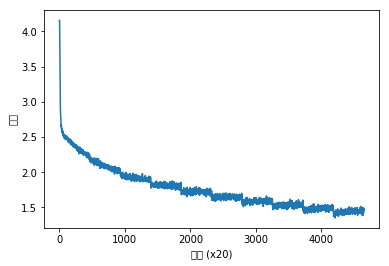

In [8]:
# 4.3.2 CBOW 모델 학습 코드
# train.py

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common import config

# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================

import pickle
from common.trainer import Trainer
from common.optimizer import Adam
# from cbow import CBOW
# from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### 모델 평가

In [9]:
# 4.3.3 CBOW 모델 평가
# eval.py

# coding: utf-8
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.732421875
 i: 0.69580078125
 your: 0.64501953125
 anything: 0.58642578125
 really: 0.5791015625

[query] year
 month: 0.83837890625
 week: 0.77490234375
 summer: 0.734375
 spring: 0.72265625
 decade: 0.68212890625

[query] car
 luxury: 0.6337890625
 truck: 0.630859375
 window: 0.6142578125
 auto: 0.5693359375
 sedan: 0.53466796875

[query] toyota
 engines: 0.63623046875
 nissan: 0.62744140625
 cars: 0.62158203125
 coated: 0.62109375
 minicomputers: 0.61865234375
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16796875
 downside: 4.86328125
 father: 4.84375
 husband: 4.72265625
 wife: 4.71875

[analogy] take:took = go:?
 eurodollars: 4.65625
 were: 4.51953125
 're: 4.26953125
 came: 4.25
 went: 4.203125

[analogy] car:cars = child:?
 a.m: 7.1953125
 children: 5.3984375
 daffynition: 5.30078125
 incest: 4.9921875
 rape: 4.78125

[analogy] good:better = bad:?
 rather: 5.0234375
 more: 4.73046875
 less: 4.70703125
 greater: 3.6

# 4.5 남은 주제

- 전이 학습
- 단어 벡터 평가


# Mini Sessions